In [52]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [53]:
finviz_url = 'https://finviz.com/quote.ashx?t='
Companys = ['AMZN', 'GOOG', 'FB'] # stock companies

news_tables = {} # Declare empty dictionary to store results from finviz

for Company in Companys:
    url = finviz_url + Company
    req = Request(url=url, headers={'user-agent':'my-app'}) # Specify headers or else access will be denied
    response = urlopen(req)
    soup = BeautifulSoup(response,features='html.parser')
    news_table = soup.find(id='news-table')
    # We get table rows
    # We get text on on td tag
    # We get time stamp on tr tag
    news_tables.update({Company:news_table}) # Key ticker (Company name) and value news_table
    

parsed_data = [] # Instantiate new list object

for Company, news_table in news_tables.items(): # This will iterate over all keys and values using the .tems() function
    for row in news_table.find_all('tr'):
        Comments = row.a.text
        date_data = row.td.text.split(' ') # Split date with space 
        # If loop to determine if date is made of 1 or 2 indexes
        if len(date_data)==1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        parsed_data.append([Company,date,time,Comments])

    

# print(parsed_data) remember the parsed data is a list of lists

df = pd.DataFrame(parsed_data, columns=['Company','Date','Time','Comments'])
# Analyse your text
vader = SentimentIntensityAnalyzer()
# When we run polarity, we get a couple of key values from the result dictionary
# 'neg', 'neu', 'pos', 'compound'
# We can pull out what ever we want to analyse from this dictionary
# Create a function and get just the compound score
# Then use the apply function to run this function
function = lambda x: vader.polarity_scores(x)['compound']
# We want to loop through our comments column
df['Compound'] = df['Comments'].apply(function)
# Convert date column to date time
#df['Date'] = pd.to_datetime(df.Date).dt.date

In [65]:
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['Comments'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound =vader.polarity_scores(df['Comments'][i])["compound"]
    pos = vader.polarity_scores(df['Comments'][i])["pos"]
    neu = vader.polarity_scores(df['Comments'][i])["neu"]
    neg = vader.polarity_scores(df['Comments'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })

In [66]:
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)
df.head()


ValueError: columns overlap but no suffix specified: Index(['Compound'], dtype='object')

The VADER algorithm outputs sentiment scores to 4 classes of sentiments
neg: Negative
neu: Neutral
pos: Positive
compound: Compound (i.e. aggregated score)

In [54]:
print(df)

    Company       Date       Time  \
0      AMZN  Aug-23-21  03:16AM     
1      AMZN  Aug-22-21  11:19AM     
2      AMZN  Aug-22-21  09:05AM     
3      AMZN  Aug-22-21  06:21AM     
4      AMZN  Aug-22-21  06:15AM     
..      ...        ...        ...   
295      FB  Aug-13-21  04:28PM     
296      FB  Aug-13-21  04:11PM     
297      FB  Aug-13-21  04:11PM     
298      FB  Aug-13-21  03:18PM     
299      FB  Aug-13-21  01:38PM     

                                              Comments  Compound  
0    Bitcoin Topping $50,000 Stirs Forecast of Run ...    0.0000  
1    Is Amazon Poised to Conquer the Department Sto...    0.4019  
2    Amazon vs. Netflix: Which Is a Better Growth S...    0.7351  
3    What Will Berkshire Hathaway Look Like After W...    0.3612  
4                Here Are 2 Overlooked Dividend Stocks   -0.0258  
..                                                 ...       ...  
295  Plymouth shooting: Facebook removes Jake Davis...   -0.4767  
296  Facebook, Amaz

In [55]:
# Get independent variables as X
X = df.iloc[: , :-1].values
Y = df.iloc[: , -1].values
#print(Y)
print(X)
# print(df)

[['AMZN' 'Aug-23-21' '03:16AM\xa0\xa0'
  'Bitcoin Topping $50,000 Stirs Forecast of Run Toward Record High']
 ['AMZN' 'Aug-22-21' '11:19AM\xa0\xa0'
  'Is Amazon Poised to Conquer the Department Store Space?']
 ['AMZN' 'Aug-22-21' '09:05AM\xa0\xa0'
  'Amazon vs. Netflix: Which Is a Better Growth Stock to Buy?']
 ...
 ['FB' 'Aug-13-21' '04:11PM\xa0\xa0'
  'Texas Cruise Outbreak; CDC Panel Backs Third Shot: Virus Update']
 ['FB' 'Aug-13-21' '03:18PM\xa0\xa0'
  'Facebook, Amazon Seek FCC Approval For Undersea Data Cable After Google: Reuters']
 ['FB' 'Aug-13-21' '01:38PM\xa0\xa0'
  'UPDATE 2-Facebook, Amazon seek U.S. approval to operate undersea data cable']]


In [56]:
# Encoding the independent variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np 

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[0,1,2,3])],remainder='passthrough') # Pass through will not encode the other columns. [3] represents index to encode
X = ct.fit_transform(X).toarray()


print(X)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [57]:
# Splitting data into Training and Test set
# We need to train data so as to avoid over fitting and under fitting
# We want the results of our Training and Test data to match
# random_state controls the shuffling applied to the data before applying the split
# test_size should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
# print(x_train)
# print(x_test)
# print(y_train)
# print(y_test)

In [58]:
# Trainig the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,max_error,explained_variance_score

regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression()

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

LogisticRegression is not for regression but classification
The Y variable must be the classification class, for example 0 or 1
And not a continuous variable,

In [59]:
# Testing 
pred = regressor.predict(x_test)
np.set_printoptions(precision=2)
joinedArrays = np.concatenate((pred.reshape(len(pred),1),y_test.reshape(len(y_test),1)),1) # Just 1 column. 0 = vertical axis and 1 = horizontal axis

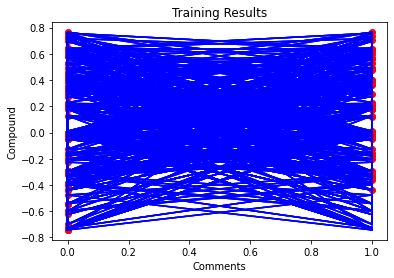

In [60]:
# Visualising training results

plt.scatter(x_train[:,0],y_train, color = 'red')
plt.plot(x_train,regressor.predict(x_train),color = 'blue')
plt.title('Training Results')
plt.xlabel('Comments')
plt.ylabel('Compound')
plt.show() 

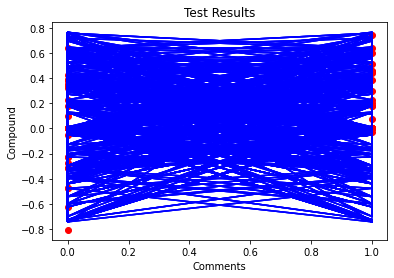

In [61]:
# Visualising test results

plt.scatter(x_test[:,0],y_test, color = 'red')
plt.plot(x_train,regressor.predict(x_train),color = 'blue')
plt.title('Test Results')
plt.xlabel('Comments')
plt.ylabel('Compound')
plt.show()

In [62]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)
model.coef_ # The linear regression coefficient can be accessed in a form of class attribute with model.coef_
model.intercept_ # The y-intercept can be accessed in a form of class attribute with model.intercept_
model.score(X, Y) # How good was your model? You can evaluate your model performance in a form of R-squared, with model.score(X, y). X is the features, and y is the response variable used to fit the model.


1.0

In [ ]:
BNBmodel = BernoulliNB()
# BNBmodel.fit(X_train, y_train)
# model_Evaluate(BNBmodel)
# y_pred1 = BNBmodel.predict(X_test)